# Advent of Code 2017

## December 3rd

You come across an experimental new kind of memory stored on an infinite two-dimensional grid.

Each square on the grid is allocated in a spiral pattern starting at a location marked 1 and then counting up while spiraling outward. For example, the first few squares are allocated like this:

    17  16  15  14  13
    18   5   4   3  12
    19   6   1   2  11
    20   7   8   9  10
    21  22  23---> ...

While this is very space-efficient (no squares are skipped), requested data must be carried back to square 1 (the location of the only access port for this memory system) by programs that can only move up, down, left, or right. They always take the shortest path: the Manhattan Distance between the location of the data and square 1.

For example:

* Data from square 1 is carried 0 steps, since it's at the access port.
* Data from square 12 is carried 3 steps, such as: down, left, left.
* Data from square 23 is carried only 2 steps: up twice.
* Data from square 1024 must be carried 31 steps.

How many steps are required to carry the data from the square identified in your puzzle input all the way to the access port?

### Analysis

I freely admit that I worked out the program I wanted to write using graph paper and some Python doodles.  There's no point in trying to write a Joy program until I'm sure I understand the problem well enough.

The first thing I did was to write a column of numbers from 1 to n (32 as it happens) and next to them the desired output number, to look for patterns directly:

    1  0
    2  1
    3  2
    4  1
    5  2
    6  1
    7  2
    8  1
    9  2
    10 3
    11 2
    12 3
    13 4
    14 3
    15 2
    16 3
    17 4
    18 3
    19 2
    20 3
    21 4
    22 3
    23 2
    24 3
    25 4
    26 5
    27 4
    28 3
    29 4
    30 5
    31 6
    32 5

There are four groups repeating for a given "rank", then the pattern enlarges and four groups repeat again, etc.

            1 2
          3 2 3 4
        5 4 3 4 5 6
      7 6 5 4 5 6 7 8
    9 8 7 6 5 6 7 8 9 10

Four of this pyramid interlock to tile the plane extending from the initial "1" square.


             2   3   |    4  5   |    6  7   |    8  9
          10 11 12 13|14 15 16 17|18 19 20 21|22 23 24 25

And so on.

We can figure out the pattern for a row of the pyramid at a given "rank" $k$:

$2k - 1, 2k - 2, ..., k, k + 1, k + 2, ..., 2k$

or

$k + (k - 1), k + (k - 2), ..., k, k + 1, k + 2, ..., k + k$

This shows that the series consists at each place of $k$ plus some number that begins at $k - 1$, decreases to zero, then increases to $k$.  Each row has $2k$ members.

Let's figure out how, given an index into a row, we can calculate the value there.  The index will be from 0 to $k - 1$. 

 Let's look at an example, with $k = 4$:

    0 1 2 3 4 5 6 7
    7 6 5 4 5 6 7 8

In [1]:
k = 4

Subtract $k$ from the index and take the absolute value:

In [2]:
for n in range(2 * k):
    print abs(n - k),

4 3 2 1 0 1 2 3


Not quite. Subtract $k - 1$ from the index and take the absolute value:

In [3]:
for n in range(2 * k):
    print abs(n - (k - 1)),

3 2 1 0 1 2 3 4


Great, now add $k$...

In [4]:
for n in range(2 * k):
    print abs(n - (k - 1)) + k,

7 6 5 4 5 6 7 8


So to write a function that can give us the value of a row at a given index:

In [5]:
def row_value(k, i):
    i %= (2 * k)  # wrap the index at the row boundary.
    return abs(i - (k - 1)) + k

In [6]:
k = 5
for i in range(2 * k):
    print row_value(k, i),

9 8 7 6 5 6 7 8 9 10


(I'm leaving out details of how I figured this all out and just giving the relevent bits.  It took a little while to zero in of the aspects of the pattern that were important for the task.)

### Finding the rank and offset of a number.
Now that we can compute the desired output value for a given rank and the offset (index) into that rank, we need to determine how to find the rank and offset of a number.

The rank is easy to find by iteratively stripping off the amount already covered by previous ranks until you find the one that brackets the target number.  Because each row is $2k$ places and there are $4$ per rank each rank contains $8k$ places.  Counting the initial square we have:

$corner_k = 1 + \sum_{n=1}^k 8n$

I'm not mathematically sophisticated enough to turn this directly into a formula (but Sympy is, see below.)  I'm going to write a simple Python function to iterate and search:

In [7]:
def rank_and_offset(n):
    assert n >= 2  # Guard the domain.
    n -= 2  # Subtract two,
            # one for the initial square,
            # and one because we are counting from 1 instead of 0.
    k = 1
    while True:
        m = 8 * k  # The number of places total in this rank, 4(2k).
        if n < m:
            return k, n % (2 * k)
        n -= m  # Remove this rank's worth.
        k += 1

In [8]:
for n in range(2, 51):
    print n, rank_and_offset(n)

2 (1, 0)
3 (1, 1)
4 (1, 0)
5 (1, 1)
6 (1, 0)
7 (1, 1)
8 (1, 0)
9 (1, 1)
10 (2, 0)
11 (2, 1)
12 (2, 2)
13 (2, 3)
14 (2, 0)
15 (2, 1)
16 (2, 2)
17 (2, 3)
18 (2, 0)
19 (2, 1)
20 (2, 2)
21 (2, 3)
22 (2, 0)
23 (2, 1)
24 (2, 2)
25 (2, 3)
26 (3, 0)
27 (3, 1)
28 (3, 2)
29 (3, 3)
30 (3, 4)
31 (3, 5)
32 (3, 0)
33 (3, 1)
34 (3, 2)
35 (3, 3)
36 (3, 4)
37 (3, 5)
38 (3, 0)
39 (3, 1)
40 (3, 2)
41 (3, 3)
42 (3, 4)
43 (3, 5)
44 (3, 0)
45 (3, 1)
46 (3, 2)
47 (3, 3)
48 (3, 4)
49 (3, 5)
50 (4, 0)


In [9]:
for n in range(2, 51):
    k, i = rank_and_offset(n)
    print n, row_value(k, i)

2 1
3 2
4 1
5 2
6 1
7 2
8 1
9 2
10 3
11 2
12 3
13 4
14 3
15 2
16 3
17 4
18 3
19 2
20 3
21 4
22 3
23 2
24 3
25 4
26 5
27 4
28 3
29 4
30 5
31 6
32 5
33 4
34 3
35 4
36 5
37 6
38 5
39 4
40 3
41 4
42 5
43 6
44 5
45 4
46 3
47 4
48 5
49 6
50 7


### Putting it all together

In [10]:
def row_value(k, i):
    return abs(i - (k - 1)) + k


def rank_and_offset(n):
    n -= 2  # Subtract two,
            # one for the initial square,
            # and one because we are counting from 1 instead of 0.
    k = 1
    while True:
        m = 8 * k  # The number of places total in this rank, 4(2k).
        if n < m:
            return k, n % (2 * k)
        n -= m  # Remove this rank's worth.
        k += 1


def aoc20173(n):
    if n <= 1:
        return 0
    k, i = rank_and_offset(n)
    return row_value(k, i)

In [11]:
aoc20173(23)

2

In [12]:
aoc20173(23000)

105

In [13]:
aoc20173(23000000000000)

4572225

# Sympy to the Rescue
### Find the rank for large numbers
Using e.g. Sympy we can find the rank directly by solving for the roots of an equation.  For large numbers this will (eventually) be faster than iterating as `rank_and_offset()` does.

In [14]:
from sympy import floor, lambdify, solve, symbols
from sympy import init_printing
init_printing() 

In [15]:
k = symbols('k')

Since

$1 + 2 + 3 + ... + N = \frac{N(N + 1)}{2}$

and

$\sum_{n=1}^k 8n = 8(\sum_{n=1}^k n) = 8\frac{k(k + 1)}{2}$

We want:

In [16]:
E = 2 + 8 * k * (k + 1) / 2  # For the reason for adding 2 see above.

E

We can write a function to solve for $k$ given some $n$...

In [17]:
def rank_of(n):
    return floor(max(solve(E - n, k))) + 1

First `solve()` for $E - n = 0$ which has two solutions (because the equation is quadratic so it has two roots) and since we only care about the larger one we use `max()` to select it.  It will generally not be a nice integer (unless $n$ is the number of an end-corner of a rank) so we take the `floor()` and add 1 to get the integer rank of $n$.  (Taking the `ceiling()` gives off-by-one errors on the rank boundaries.  I don't know why.  I'm basically like a monkey doing math here.)  =-D

It gives correct answers:

In [18]:
for n in (9, 10, 25, 26, 49, 50):
    print n, rank_of(n)

9 1
10 2
25 2
26 3
49 3
50 4


And it runs much faster (at least for large numbers):

In [19]:
%time rank_of(23000000000000)  # Compare runtime with rank_and_offset()!

CPU times: user 68 ms, sys: 8 ms, total: 76 ms
Wall time: 73.8 ms


In [20]:
%time rank_and_offset(23000000000000)

CPU times: user 308 ms, sys: 0 ns, total: 308 ms
Wall time: 306 ms


After finding the rank you would still have to find the actual value of the rank's first corner and subtract it (plus 2) from the number and compute the offset as above and then the final output, but this overhead is partially shared by the other method, and overshadowed by the time it (the other iterative method) would take for really big inputs.

The fun thing to do here would be to graph the actual runtime of both methods against each other to find the trade-off point.

### It took me a second to realize I could do this...
Sympy is a *symbolic* math library, and it supports symbolic manipulation of equations.  I can put in $y$ (instead of a value) and ask it to solve for $k$.

In [21]:
y = symbols('y')

In [22]:
g, f = solve(E - y, k)

The equation is quadratic so there are two roots, we are interested in the greater one...

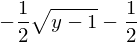

In [23]:
g

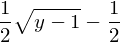

In [24]:
f

Now we can take the `floor()`, add 1, and `lambdify()` the equation to get a Python function that calculates the rank directly.

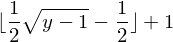

In [25]:
floor(f) + 1

In [26]:
F = lambdify(y, floor(f) + 1)

In [27]:
for n in (9, 10, 25, 26, 49, 50):
    print n, int(F(n))

9 1
10 2
25 2
26 3
49 3
50 4


It's pretty fast.

In [28]:
%time int(F(23000000000000))  # The clear winner.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs


Knowing the equation we could write our own function manually, but the speed is no better.

In [29]:
from math import floor as mfloor, sqrt

def mrank_of(n):
    return int(mfloor(sqrt(23000000000000 - 1) / 2 - 0.5) + 1)

In [30]:
%time mrank_of(23000000000000)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.9 µs


### Given $n$ and a rank, compute the offset.

Now that we have a fast way to get the rank, we still need to use it to compute the offset into a pyramid row.

In [31]:
def offset_of(n, k):
    return (n - 2 + 4 * k * (k - 1)) % (2 * k)

(Note the sneaky way the sign changes from $k(k + 1)$ to $k(k - 1)$.  This is because we want to subract the $(k - 1)$th rank's total places (its own and those of lesser rank) from our $n$ of rank $k$.  Substituting $k - 1$ for $k$ in $k(k + 1)$ gives $(k - 1)(k - 1 + 1)$, which of course simplifies to $k(k - 1)$.)

In [32]:
offset_of(23000000000000, 2397916)

So, we can compute the rank, then the offset, then the row value.

In [33]:
def rank_of(n):
    return int(mfloor(sqrt(n - 1) / 2 - 0.5) + 1)


def offset_of(n, k):
    return (n - 2 + 4 * k * (k - 1)) % (2 * k)


def row_value(k, i):
    return abs(i - (k - 1)) + k


def aoc20173(n):
    k = rank_of(n)
    i = offset_of(n, k)
    return row_value(k, i)

In [34]:
aoc20173(23)

In [35]:
aoc20173(23000)

In [36]:
aoc20173(23000000000000)

In [37]:
%time aoc20173(23000000000000000000000000)  # Fast for large values.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 20 µs


# A Joy Version
At this point I feel confident that I can implement a concise version of this code in Joy.  ;-)

In [38]:
from notebook_preamble import J, V, define

### `rank_of`

       n rank_of
    ---------------
          k

The translation is straightforward.

    int(floor(sqrt(n - 1) / 2 - 0.5) + 1)

    rank_of == -- sqrt 2 / 0.5 - floor ++

In [39]:
define('rank_of == -- sqrt 2 / 0.5 - floor ++')

### `offset_of`

       n k offset_of
    -------------------
             i

    (n - 2 + 4 * k * (k - 1)) % (2 * k)

A little tricky...

    n k dup 2 *
    n k k 2 *
    n k k*2 [Q] dip %
    n k Q k*2 %

    n k dup --
    n k k --
    n k k-1 4 * * 2 + -
    n k*k-1*4     2 + -
    n k*k-1*4+2       -
    n-k*k-1*4+2

    n-k*k-1*4+2 k*2 %
    n-k*k-1*4+2%k*2

Ergo:

    offset_of == dup 2 * [dup -- 4 * * 2 + -] dip %

In [40]:
define('offset_of == dup 2 * [dup -- 4 * * 2 + -] dip %')

### `row_value`

       k i row_value
    -------------------
            n

    abs(i - (k - 1)) + k

    k i over -- - abs +
    k i k    -- - abs +
    k i k-1     - abs +
    k i-k-1       abs +
    k |i-k-1|         +
    k+|i-k-1|

In [41]:
define('row_value == over -- - abs +')

### `aoc2017.3`

       n aoc2017.3
    -----------------
            m

    n dup rank_of
    n k [offset_of] dupdip
    n k offset_of k
    i             k swap row_value
    k i row_value
    m

In [42]:
define('aoc2017.3 == dup rank_of [offset_of] dupdip swap row_value')

In [43]:
J('23 aoc2017.3')

2


In [44]:
J('23000 aoc2017.3')

105


In [45]:
V('23000000000000 aoc2017.3')

                                                    . 23000000000000 aoc2017.3
                                     23000000000000 . aoc2017.3
                                     23000000000000 . dup rank_of [offset_of] dupdip swap row_value
                      23000000000000 23000000000000 . rank_of [offset_of] dupdip swap row_value
                      23000000000000 23000000000000 . -- sqrt 2 / 0.5 - floor ++ [offset_of] dupdip swap row_value
                      23000000000000 22999999999999 . sqrt 2 / 0.5 - floor ++ [offset_of] dupdip swap row_value
                   23000000000000 4795831.523312615 . 2 / 0.5 - floor ++ [offset_of] dupdip swap row_value
                 23000000000000 4795831.523312615 2 . / 0.5 - floor ++ [offset_of] dupdip swap row_value
                  23000000000000 2397915.7616563076 . 0.5 - floor ++ [offset_of] dupdip swap row_value
              23000000000000 2397915.7616563076 0.5 . - floor ++ [offset_of] dupdip swap row_value
                  23

      rank_of == -- sqrt 2 / 0.5 - floor ++
    offset_of == dup 2 * [dup -- 4 * * 2 + -] dip %
    row_value == over -- - abs +

    aoc2017.3 == dup rank_of [offset_of] dupdip swap row_value